## Pertpy cell type priorization with Augur

In [1]:
import scanpy as sc
import pertpy as pt
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3               
sc.logging.print_version_and_date()

# making sure plots & clusters are reproducible
np.random.seed(42)

Running Scanpy 1.10.2, on 2024-09-04 12:55.


In [2]:
## plotting variables
plot_folder = "/media/HDD_1/Michael/Michelangelo/aging/augurpy/"
sc.set_figure_params(vector_friendly = True)
plt.rcParams['figure.figsize'] = (6, 5)
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['pdf.fonttype'] = 42

In [3]:
object_folder = "/media/HDD_1/Janine/Aging_SingleCell/data_objects/"
adata = sc.read(object_folder + "230111_Bleo_Ageing_annotated_final.h5ad") ### 3.9 GB ###

In [4]:
## have a look at the adata object
adata

AnnData object with n_obs × n_vars = 160477 × 29814
    obs: 'age', 'barcode', 'batch', 'day', 'name', 'sex', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'doublet_scores', 'size_factors', 'S_score', 'G2M_score', 'phase', 'time_point', 'leiden_1', 'leiden_2', 'domain', 'cell_type', 'ct_level2', 'compartment_label', 'meta_label', 'age_treatment', 'age_day'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'age_colors', 'age_day_colors', 'age_treatment_colors', 'batch_colors', 'cell_type_colors', 'compartment_label_colors', 'ct_level2_colors', 'day_colors', 'dendrogram_cell_type', 'domain_colors', 'hvg', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'meta_label_colors', 'name_colors', 'neighbors', 'pca', 'sex_colors', 'time_point_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connect

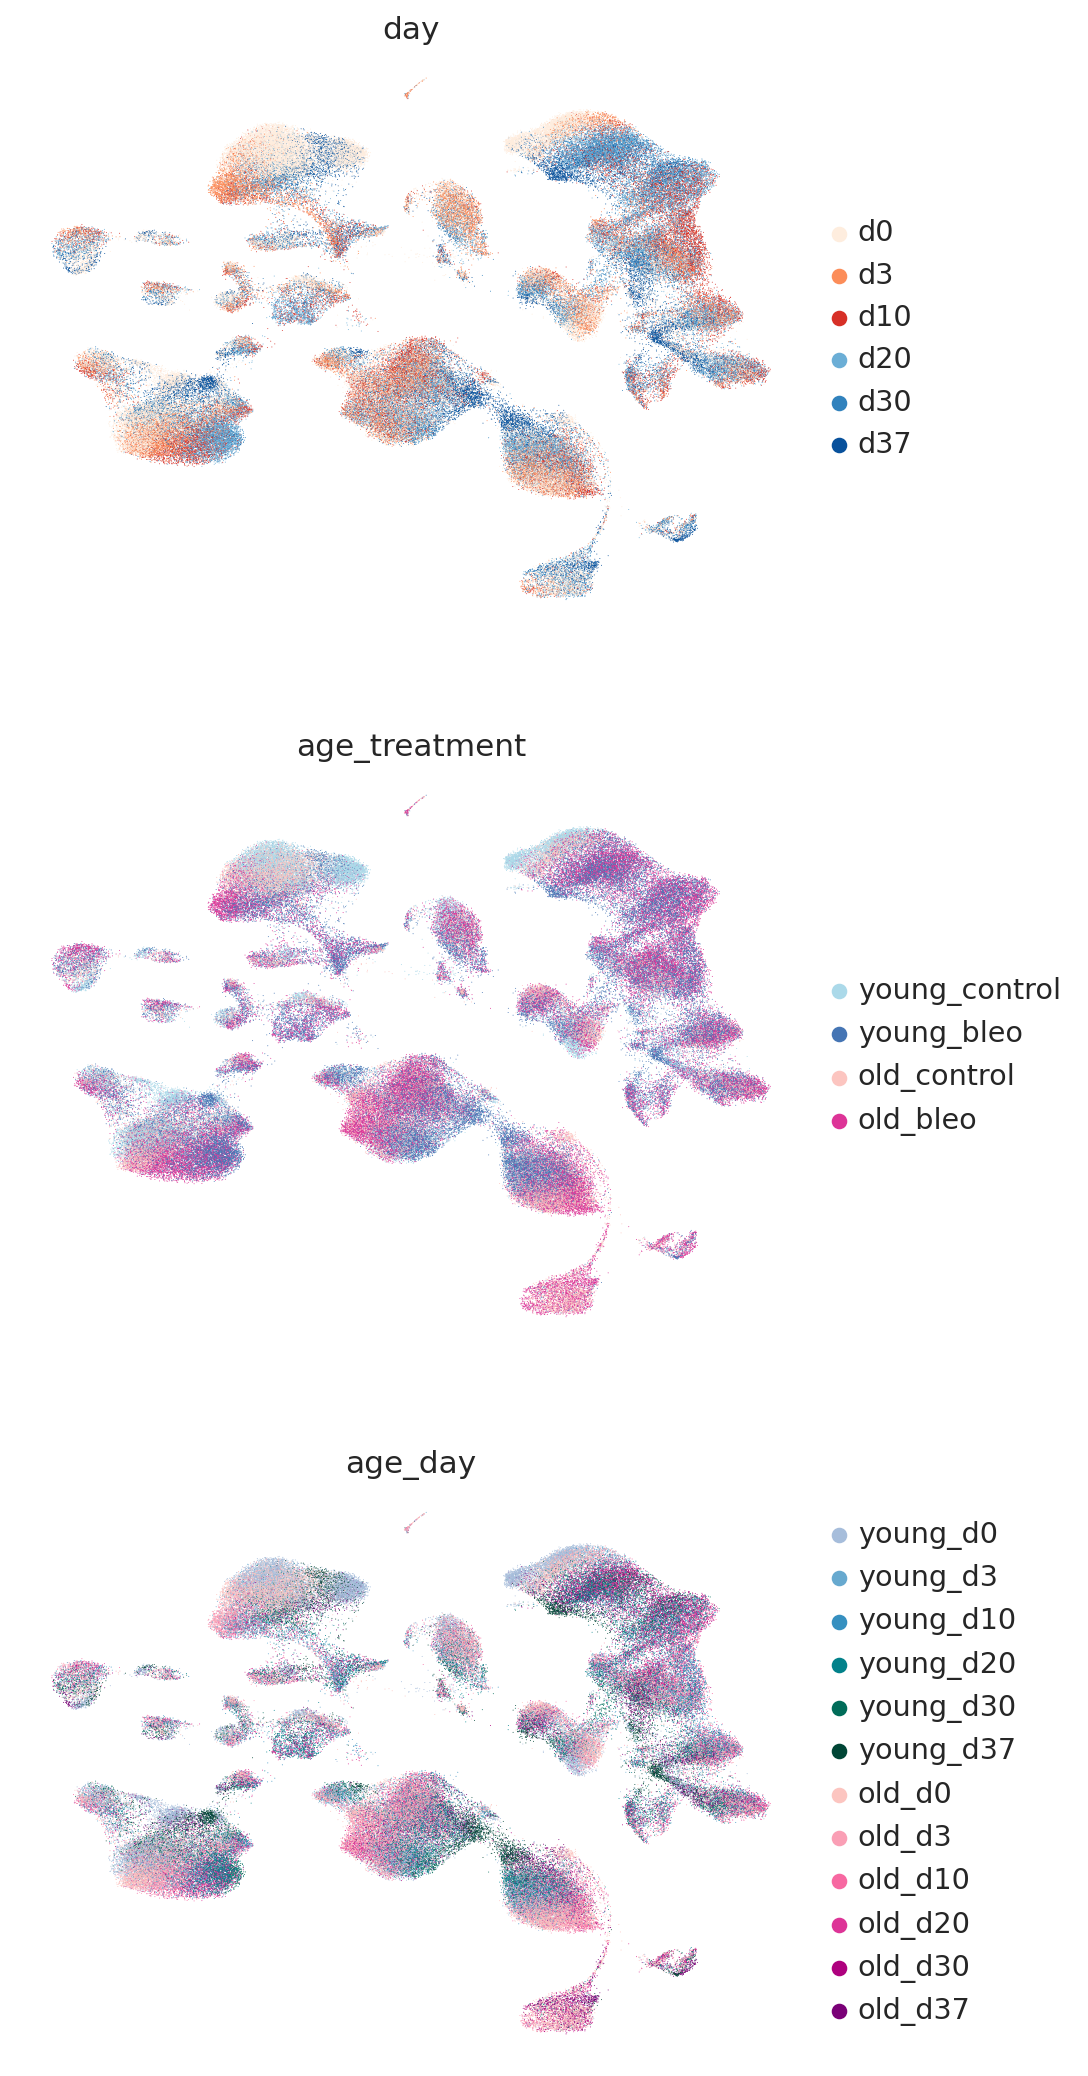

In [5]:
sc.pl.umap(adata, color = ['day','age_treatment', "age_day"], ncols = 1, frameon = False)

In [6]:
adata.obs.age_day.value_counts()

age_day
young_d0     29048
old_d0       24730
old_d10      13163
old_d20      12281
young_d10    11954
young_d20    11729
young_d30    11099
old_d3       10957
young_d3     10544
old_d30       8915
young_d37     8619
old_d37       7438
Name: count, dtype: int64

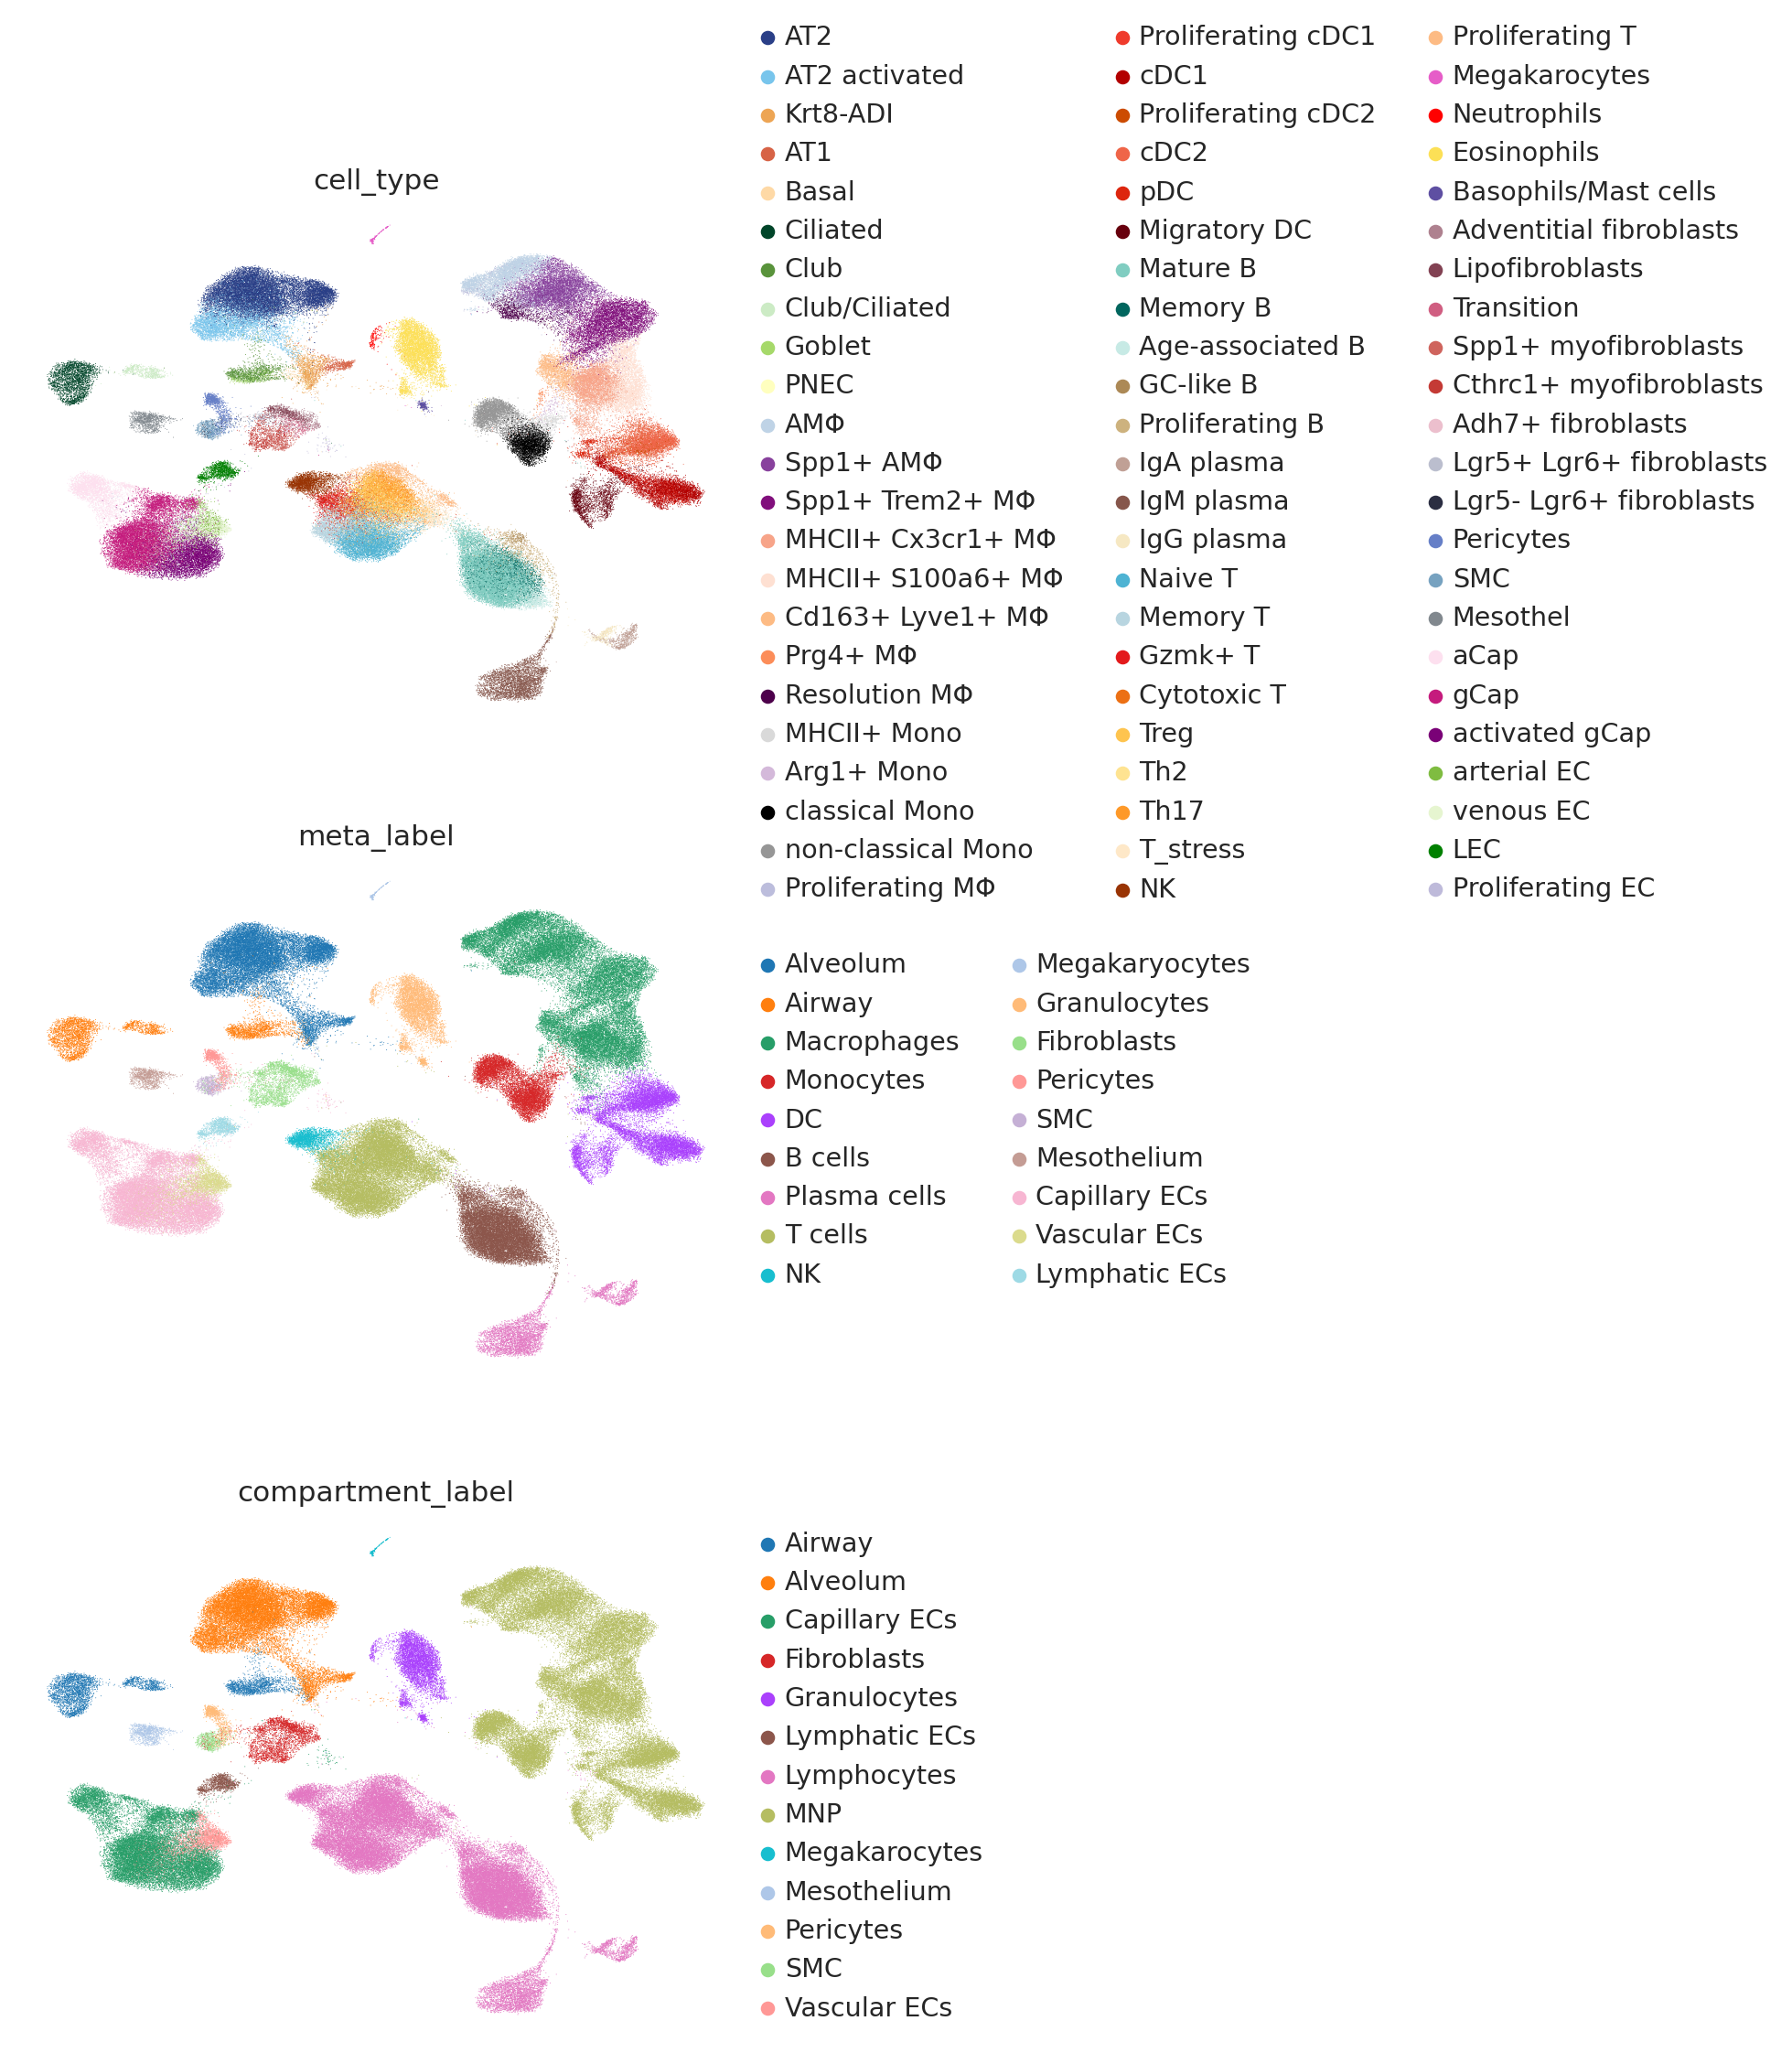

In [7]:
## overview UMAPs
sc.pl.umap(adata, color = ['cell_type','meta_label', 'compartment_label'], ncols = 1, frameon = False)

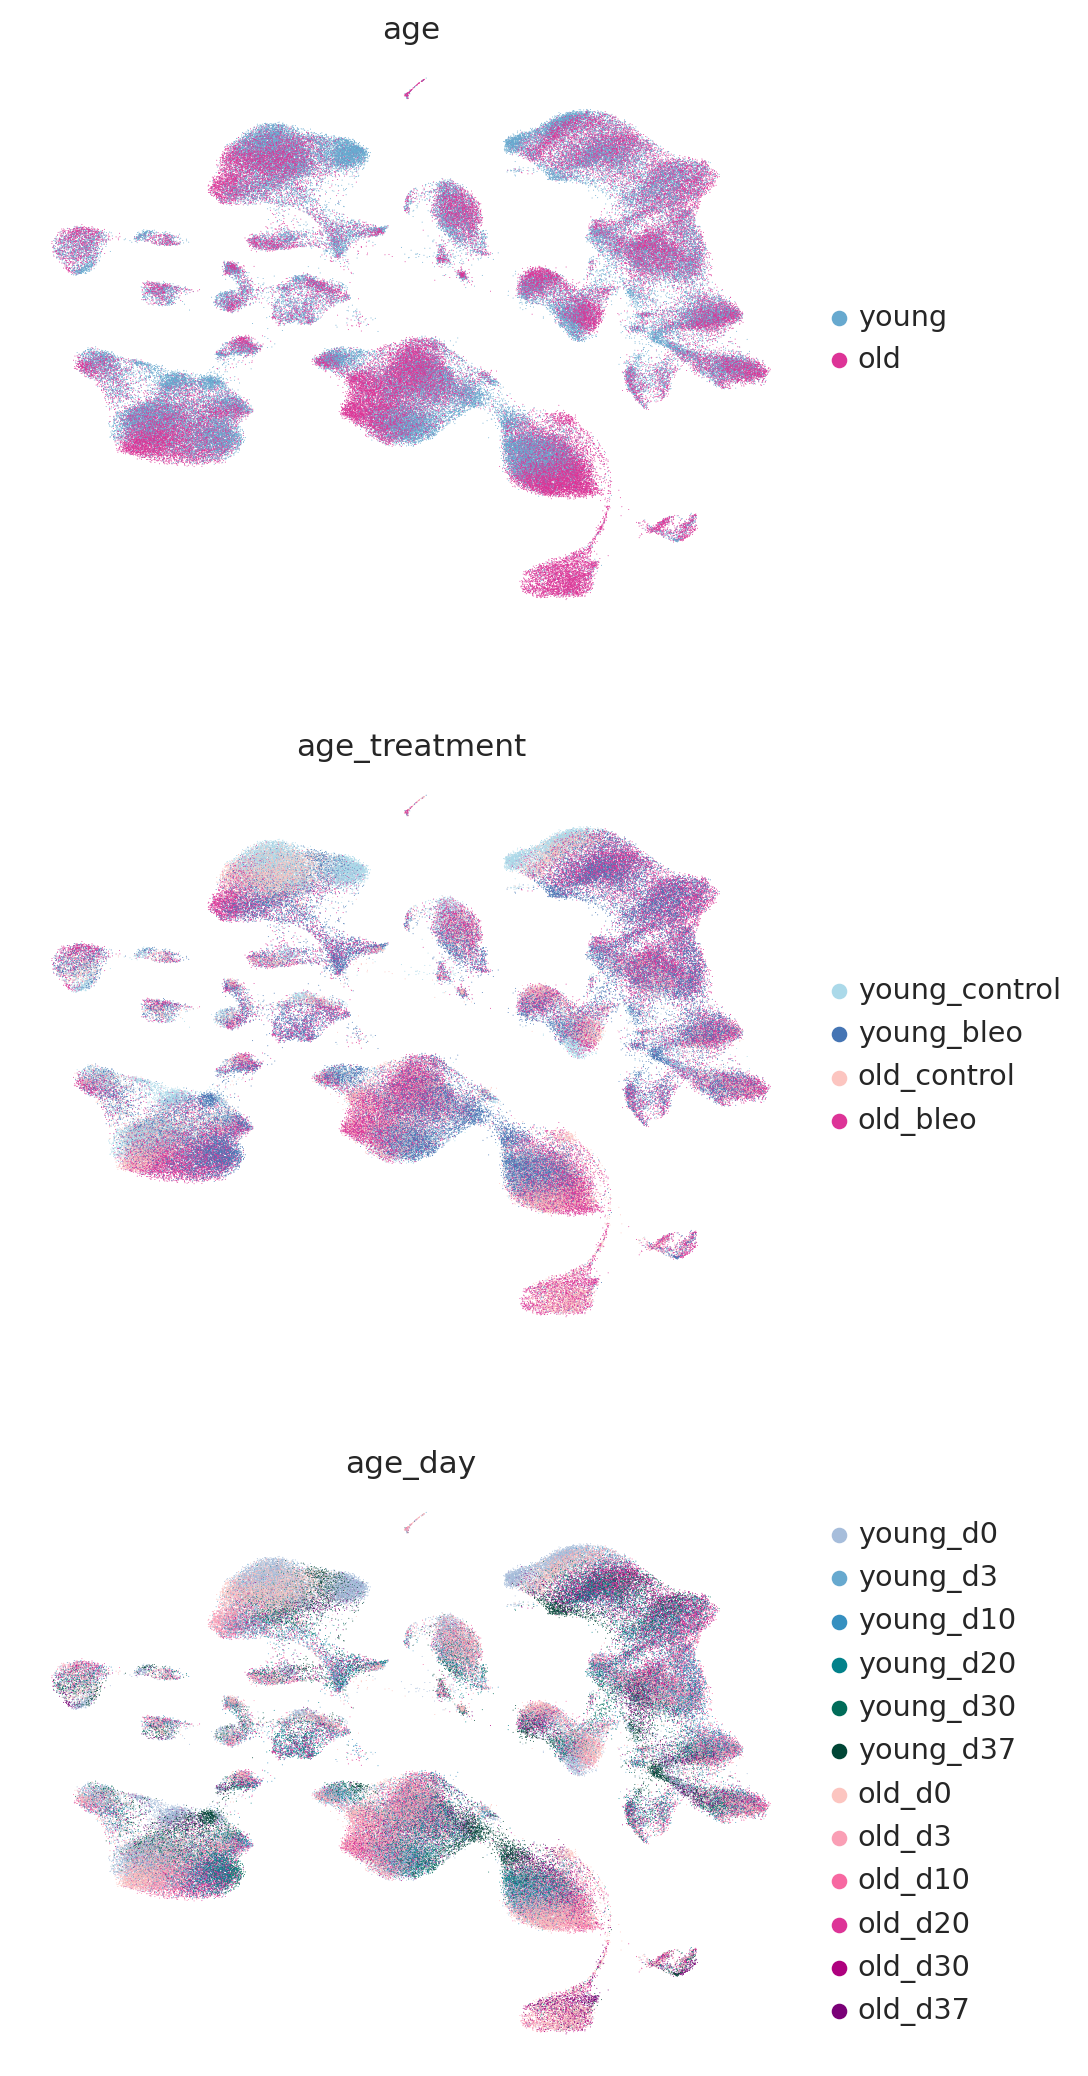

In [8]:
sc.pl.umap(adata, color = ['age','age_treatment', "age_day"], ncols = 1, frameon = False)

In [9]:
adata = adata[-adata.obs.compartment_label.isin(['Megakarocytes'])].copy()

In [10]:
pd.crosstab(adata.obs['age_treatment'],adata.obs['meta_label'])

meta_label     Alveolum  Airway  Macrophages  Monocytes    DC  B cells  \
age_treatment                                                            
young_control      7531    1103         3576       1898  1415     2484   
young_bleo         5016    1494        13181       2024  5365     5271   
old_control        4019     769         2233       1741  1395     3481   
old_bleo           3180    1381        12139       2361  4724     6018   

meta_label     Plasma cells  T cells   NK  Granulocytes  Fibroblasts  \
age_treatment                                                          
young_control            75     2770  667          1303          444   
young_bleo              467     7882  900          1751         1345   
old_control            1643     3599  297          1005          297   
old_bleo               2456     9296  383          1882          960   

meta_label     Pericytes  SMC  Mesothelium  Capillary ECs  Vascular ECs  \
age_treatment                                                             
young_control        225  212          221           4345           583   
young_bleo           386  210          357           6831          1013   
old_control          155  115          191           3075           495   
old_bleo             291  180          297           5724           998   

meta_label     Lymphatic ECs  
age_treatment                 
young_control            165  
young_bleo               438  
old_control              170  
old_bleo                 427

In [11]:
pd.crosstab(adata.obs['age_treatment'],adata.obs['cell_type'])

cell_type       AT2  AT2 activated  Krt8-ADI  AT1  Basal  Ciliated  Club  \
age_treatment                                                              
young_control  7240            173        55   63      4       571   271   
young_bleo     1583           2310       821  302     67       788   407   
old_control    3603            307        40   69     12       386   219   
old_bleo        691           1963       373  153     58       710   387   

cell_type      Club/Ciliated  Goblet  PNEC  ...  Pericytes  SMC  Mesothel  \
age_treatment                               ...                             
young_control            212      39     6  ...        225  212       221   
young_bleo               151      71    10  ...        386  210       357   
old_control               96      54     2  ...        155  115       191   
old_bleo                 143      78     5  ...        291  180       297   

cell_type      aCap  gCap  activated gCap  arterial EC  venous EC  LEC  \
age_treatment                                                            
young_control   813  3322              80          230        353  165   
young_bleo      925  2724            2853          306        707  438   
old_control     497  2323             120          121        374  170   
old_bleo        667  2406            2432          214        784  427   

cell_type      Proliferating EC  
age_treatment                    
young_control               130  
young_bleo                  329  
old_control                 135  
old_bleo                    219  

[4 rows x 68 columns]

In [12]:
## random forest classifier for categorical 'age_treatment' variable
ag_rfc = pt.tl.Augur("random_forest_classifier")

In [13]:
adata.obs.rename(columns = {'cell_type': 'cell_type_resolved'}, inplace=True)

In [15]:
adata = adata[adata.obs.age_treatment.isin(['old_control','old_bleo'])].copy()

In [16]:
pd.crosstab(adata.obs['age_treatment'],adata.obs['time_point'])

time_point        d0     d3    d10    d20   d30   d37
age_treatment                                        
old_control    24680      0      0      0     0     0
old_bleo           0  10923  13146  12278  8912  7438

In [17]:
adata.obs.time_point

muc26496_GCCTCCACAAGA    d0
muc26496_CCAGGCCATTCA    d0
muc26496_CGTCCAGAACTA    d0
muc26496_CCGAGTACGCGA    d0
muc26496_CTAGTCGAAACG    d0
                         ..
muc26548_GCGCCTAACGAC    d0
muc26548_AGGCCTAAACTC    d0
muc26548_CGACTGCTGTAG    d0
muc26548_TACTCCAGCAGA    d0
muc26548_CATTGACCTGGC    d0
Name: time_point, Length: 77377, dtype: category
Categories (6, object): ['d0', 'd3', 'd10', 'd20', 'd30', 'd37']

In [18]:
adata1 = adata[adata.obs.time_point.isin(['d0','d3'])].copy()
adata2 = adata[adata.obs.time_point.isin(['d0','d10'])].copy()
adata3 = adata[adata.obs.time_point.isin(['d0','d20'])].copy()
adata4 = adata[adata.obs.time_point.isin(['d0','d30'])].copy()
adata5 = adata[adata.obs.time_point.isin(['d0','d37'])].copy()

In [19]:
loaded_data1 = ag_rfc.load(adata1, label_col="age_treatment", cell_type_col="meta_label")
loaded_data1

AnnData object with n_obs × n_vars = 35603 × 29814
    obs: 'age', 'barcode', 'batch', 'day', 'name', 'sex', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'doublet_scores', 'size_factors', 'S_score', 'G2M_score', 'phase', 'time_point', 'leiden_1', 'leiden_2', 'domain', 'cell_type_resolved', 'ct_level2', 'compartment_label', 'cell_type', 'label', 'age_day', 'y_'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'age_colors', 'age_day_colors', 'age_treatment_colors', 'batch_colors', 'cell_type_colors', 'compartment_label_colors', 'ct_level2_colors', 'day_colors', 'dendrogram_cell_type', 'domain_colors', 'hvg', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'meta_label_colors', 'neighbors', 'pca', 'sex_colors', 'time_point_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connectivities', 

In [20]:
loaded_data1.obs

age barcode          batch day        name     sex  \
muc26496_GCCTCCACAAGA  old    N704  ageing_pool_1  d0  oCm_d0_M55    male   
muc26496_CCAGGCCATTCA  old    N704  ageing_pool_1  d0  oCm_d0_M55    male   
muc26496_CGTCCAGAACTA  old    N704  ageing_pool_1  d0  oCm_d0_M55    male   
muc26496_CCGAGTACGCGA  old    N704  ageing_pool_1  d0  oCm_d0_M55    male   
muc26496_CTAGTCGAAACG  old    N704  ageing_pool_1  d0  oCm_d0_M55    male   
...                    ...     ...            ...  ..         ...     ...   
muc26548_GCGCCTAACGAC  old    N706  ageing_pool_4  d0  oCf-d0-M57  female   
muc26548_AGGCCTAAACTC  old    N706  ageing_pool_4  d0  oCf-d0-M57  female   
muc26548_CGACTGCTGTAG  old    N706  ageing_pool_4  d0  oCf-d0-M57  female   
muc26548_TACTCCAGCAGA  old    N706  ageing_pool_4  d0  oCf-d0-M57  female   
muc26548_CATTGACCTGGC  old    N706  ageing_pool_4  d0  oCf-d0-M57  female   

                      treatment identifier  n_counts  n_genes  ...  leiden_1  \
muc26496_GCCTCCACAAGA   control   muc26496   13182.0     4256  ...         0   
muc26496_CCAGGCCATTCA   control   muc26496   12916.0     3938  ...        11   
muc26496_CGTCCAGAACTA   control   muc26496   11497.0     3825  ...        18   
muc26496_CCGAGTACGCGA   control   muc26496   11458.0     4206  ...        19   
muc26496_CTAGTCGAAACG   control   muc26496   10868.0     3246  ...         3   
...                         ...        ...       ...      ...  ...       ...   
muc26548_GCGCCTAACGAC   control   muc26548     805.0      470  ...        13   
muc26548_AGGCCTAAACTC   control   muc26548     805.0      557  ...         0   
muc26548_CGACTGCTGTAG   control   muc26548     804.0      524  ...         4   
muc26548_TACTCCAGCAGA   control   muc26548     803.0      432  ...         5   
muc26548_CATTGACCTGGC   control   muc26548     803.0      550  ...         6   

                       leiden_2       domain  cell_type_resolved  \
muc26496_GCCTCCACAAGA        25  Endothelium           venous EC   
muc26496_CCAGGCCATTCA        13   Leukocytes  Proliferating cDC2   
muc26496_CGTCCAGAACTA        23  Endothelium                aCap   
muc26496_CCGAGTACGCGA        24   Epithelium            Ciliated   
muc26496_CTAGTCGAAACG        17   Leukocytes   MHCII+ S100a6+ ΜΦ   
...                         ...          ...                 ...   
muc26548_GCGCCTAACGAC        10   Leukocytes         Eosinophils   
muc26548_AGGCCTAAACTC         2  Endothelium                gCap   
muc26548_CGACTGCTGTAG         1   Leukocytes             Gzmk+ T   
muc26548_TACTCCAGCAGA         6   Epithelium                 AT2   
muc26548_CATTGACCTGGC         4   Leukocytes                Th17   

                              ct_level2 compartment_label      cell_type  \
muc26496_GCCTCCACAAGA         venous EC      Vascular ECs   Vascular ECs   
muc26496_CCAGGCCATTCA  Proliferating DC               MNP             DC   
muc26496_CGTCCAGAACTA              aCap     Capillary ECs  Capillary ECs   
muc26496_CCGAGTACGCGA          Ciliated            Airway         Airway   
muc26496_CTAGTCGAAACG         MHCII+ ΜΦ               MNP    Macrophages   
...                                 ...               ...            ...   
muc26548_GCGCCTAACGAC       Eosinophils      Granulocytes   Granulocytes   
muc26548_AGGCCTAAACTC              gCap     Capillary ECs  Capillary ECs   
muc26548_CGACTGCTGTAG           Gzmk+ T       Lymphocytes        T cells   
muc26548_TACTCCAGCAGA               AT2          Alveolum       Alveolum   
muc26548_CATTGACCTGGC           Thelper       Lymphocytes        T cells   

                             label age_day y_  
muc26496_GCCTCCACAAGA  old_control  old_d0  1  
muc26496_CCAGGCCATTCA  old_control  old_d0  1  
muc26496_CGTCCAGAACTA  old_control  old_d0  1  
muc26496_CCGAGTACGCGA  old_control  old_d0  1  
muc26496_CTAGTCGAAACG  old_control  old_d0  1  
...                            ...     ... ..  
muc26548_GCGCCTAACGAC  old_control  old_d0  1  
muc26548_AGGCCTAAACTC  

In [21]:
loaded_data1.obs

age barcode          batch day        name     sex  \
muc26496_GCCTCCACAAGA  old    N704  ageing_pool_1  d0  oCm_d0_M55    male   
muc26496_CCAGGCCATTCA  old    N704  ageing_pool_1  d0  oCm_d0_M55    male   
muc26496_CGTCCAGAACTA  old    N704  ageing_pool_1  d0  oCm_d0_M55    male   
muc26496_CCGAGTACGCGA  old    N704  ageing_pool_1  d0  oCm_d0_M55    male   
muc26496_CTAGTCGAAACG  old    N704  ageing_pool_1  d0  oCm_d0_M55    male   
...                    ...     ...            ...  ..         ...     ...   
muc26548_GCGCCTAACGAC  old    N706  ageing_pool_4  d0  oCf-d0-M57  female   
muc26548_AGGCCTAAACTC  old    N706  ageing_pool_4  d0  oCf-d0-M57  female   
muc26548_CGACTGCTGTAG  old    N706  ageing_pool_4  d0  oCf-d0-M57  female   
muc26548_TACTCCAGCAGA  old    N706  ageing_pool_4  d0  oCf-d0-M57  female   
muc26548_CATTGACCTGGC  old    N706  ageing_pool_4  d0  oCf-d0-M57  female   

                      treatment identifier  n_counts  n_genes  ...  leiden_1  \
muc26496_GCCTCCACAAGA   control   muc26496   13182.0     4256  ...         0   
muc26496_CCAGGCCATTCA   control   muc26496   12916.0     3938  ...        11   
muc26496_CGTCCAGAACTA   control   muc26496   11497.0     3825  ...        18   
muc26496_CCGAGTACGCGA   control   muc26496   11458.0     4206  ...        19   
muc26496_CTAGTCGAAACG   control   muc26496   10868.0     3246  ...         3   
...                         ...        ...       ...      ...  ...       ...   
muc26548_GCGCCTAACGAC   control   muc26548     805.0      470  ...        13   
muc26548_AGGCCTAAACTC   control   muc26548     805.0      557  ...         0   
muc26548_CGACTGCTGTAG   control   muc26548     804.0      524  ...         4   
muc26548_TACTCCAGCAGA   control   muc26548     803.0      432  ...         5   
muc26548_CATTGACCTGGC   control   muc26548     803.0      550  ...         6   

                       leiden_2       domain  cell_type_resolved  \
muc26496_GCCTCCACAAGA        25  Endothelium           venous EC   
muc26496_CCAGGCCATTCA        13   Leukocytes  Proliferating cDC2   
muc26496_CGTCCAGAACTA        23  Endothelium                aCap   
muc26496_CCGAGTACGCGA        24   Epithelium            Ciliated   
muc26496_CTAGTCGAAACG        17   Leukocytes   MHCII+ S100a6+ ΜΦ   
...                         ...          ...                 ...   
muc26548_GCGCCTAACGAC        10   Leukocytes         Eosinophils   
muc26548_AGGCCTAAACTC         2  Endothelium                gCap   
muc26548_CGACTGCTGTAG         1   Leukocytes             Gzmk+ T   
muc26548_TACTCCAGCAGA         6   Epithelium                 AT2   
muc26548_CATTGACCTGGC         4   Leukocytes                Th17   

                              ct_level2 compartment_label      cell_type  \
muc26496_GCCTCCACAAGA         venous EC      Vascular ECs   Vascular ECs   
muc26496_CCAGGCCATTCA  Proliferating DC               MNP             DC   
muc26496_CGTCCAGAACTA              aCap     Capillary ECs  Capillary ECs   
muc26496_CCGAGTACGCGA          Ciliated            Airway         Airway   
muc26496_CTAGTCGAAACG         MHCII+ ΜΦ               MNP    Macrophages   
...                                 ...               ...            ...   
muc26548_GCGCCTAACGAC       Eosinophils      Granulocytes   Granulocytes   
muc26548_AGGCCTAAACTC              gCap     Capillary ECs  Capillary ECs   
muc26548_CGACTGCTGTAG           Gzmk+ T       Lymphocytes        T cells   
muc26548_TACTCCAGCAGA               AT2          Alveolum       Alveolum   
muc26548_CATTGACCTGGC           Thelper       Lymphocytes        T cells   

                             label age_day y_  
muc26496_GCCTCCACAAGA  old_control  old_d0  1  
muc26496_CCAGGCCATTCA  old_control  old_d0  1  
muc26496_CGTCCAGAACTA  old_control  old_d0  1  
muc26496_CCGAGTACGCGA  old_control  old_d0  1  
muc26496_CTAGTCGAAACG  old_control  old_d0  1  
...                            ...     ... ..  
muc26548_GCGCCTAACGAC  old_control  old_d0  1  
muc26548_AGGCCTAAACTC  

In [22]:
loaded_data2 = ag_rfc.load(adata2, label_col="age_treatment", cell_type_col="meta_label")
loaded_data3 = ag_rfc.load(adata3, label_col="age_treatment", cell_type_col="meta_label")
loaded_data4 = ag_rfc.load(adata4, label_col="age_treatment", cell_type_col="meta_label")
loaded_data5 = ag_rfc.load(adata5, label_col="age_treatment", cell_type_col="meta_label")

In [23]:
loaded_data1.var['name'] = loaded_data1.var_names

In [24]:
loaded_data2.var['name'] = loaded_data2.var_names

In [25]:
loaded_data3.var['name'] = loaded_data3.var_names

In [26]:
loaded_data4.var['name'] = loaded_data4.var_names

In [27]:
loaded_data5.var['name'] = loaded_data5.var_names

In [28]:
d3_adata, d3_results = ag_rfc.predict(
    loaded_data1, n_subsamples=50, subsample_size=20, n_threads=32, select_variance_features=True)

d3_results["summary_metrics"]

Set smaller span value in the case of a `segmentation fault` error.

Set larger span in case of svddc or other near singularities error.

Output()

Vascular ECs        DC  Capillary ECs    Airway  \
mean_augur_score      0.556236  0.594161       0.581531  0.602392   
mean_auc              0.556236  0.594161       0.581531  0.602392   
mean_accuracy         0.522674  0.548425       0.543883  0.576190   
mean_precision        0.525670  0.546166       0.547261  0.576018   
mean_f1               0.477131  0.529842       0.532040  0.574159   
mean_recall           0.499841  0.576190       0.583810  0.618730   

                  Macrophages  Alveolum   T cells  Monocytes  Plasma cells  \
mean_augur_score     0.650397  0.700998  0.534127   0.553277      0.635181   
mean_auc             0.650397  0.700998  0.534127   0.553277      0.635181   
mean_accuracy        0.609377  0.622894  0.533260   0.530147      0.584505   
mean_precision       0.591778  0.602243  0.536733   0.530261      0.620665   
mean_f1              0.654710  0.675863  0.483424   0.502061      0.507912   
mean_recall          0.770317  0.816984  0.511270   0.528254      0.483810   

                       SMC   B cells  Fibroblasts        NK  Lymphatic ECs  \
mean_augur_score  0.606905  0.527868     0.604399  0.564059       0.537528   
mean_auc          0.606905  0.527868     0.604399  0.564059       0.537528   
mean_accuracy     0.557289  0.516667     0.554066  0.525824       0.519267   
mean_precision    0.555821  0.510183     0.545824  0.555381       0.535832   
mean_f1           0.556234  0.445216     0.552958  0.441563       0.491090   
mean_recall       0.630635  0.446825     0.625397  0.437937       0.522222   

                  Mesothelium  Pericytes  Granulocytes  
mean_augur_score     0.549546   0.538605      0.556973  
mean_auc             0.549546   0.538605      0.556973  
mean_accuracy        0.510733   0.530110      0.535641  
mean_precision       0.526087   0.532665      0.561391  
mean_f1              0.418303   0.444849      0.465769  
mean_recall          0.415714   0.461746      0.448095

/tmp/ipykernel_2045766/1878953235.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  pt.pl.ag.lollipop(d3_results)


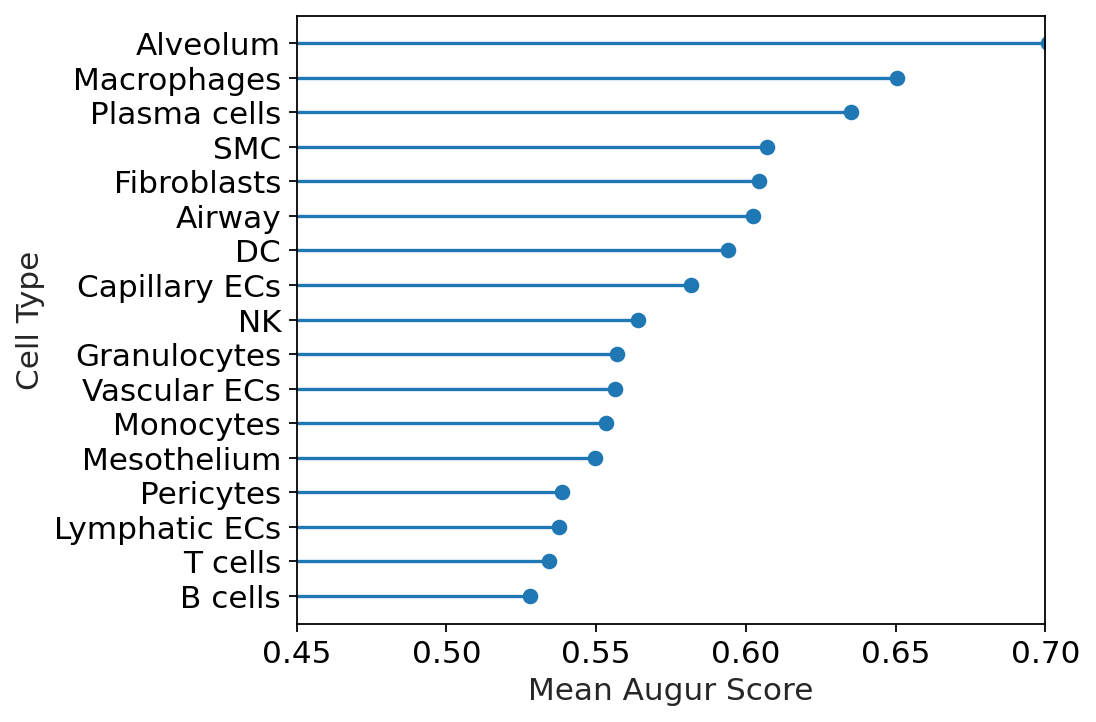

In [29]:
pt.pl.ag.lollipop(d3_results)
plt.xlim([0.45, 0.7])
#plt.yticks(fontsize = 5) 
plt.grid(False)
#plt.savefig(plot_folder + 'pertpy_meta_young.pdf')

/tmp/ipykernel_2045766/2782097142.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  important_features = pt.pl.ag.important_features(d3_results, top_n=15)


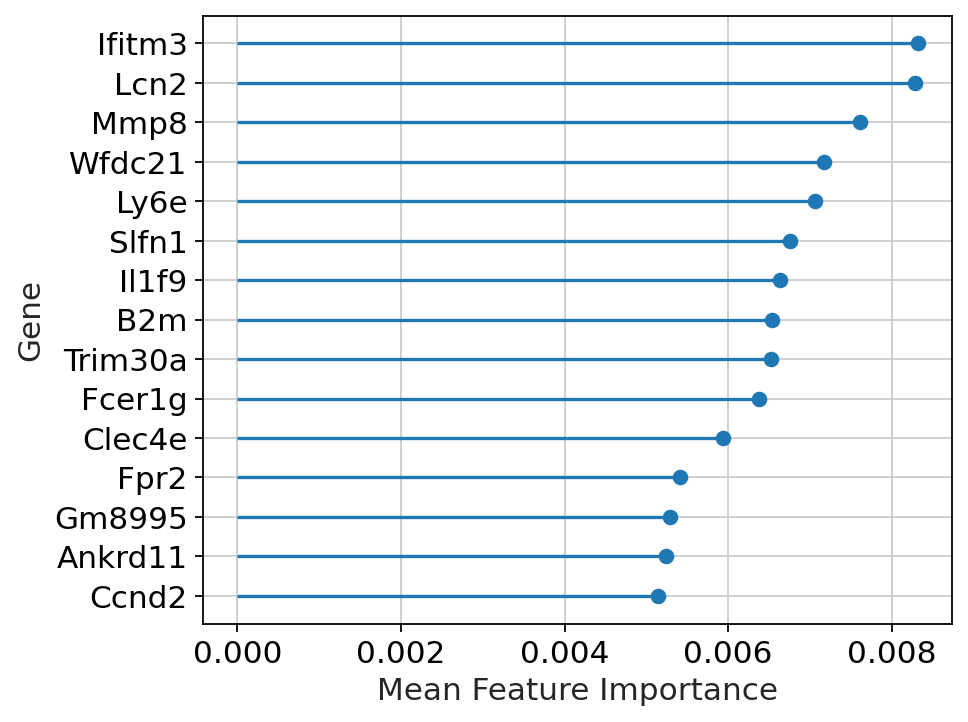

In [30]:
important_features = pt.pl.ag.important_features(d3_results, top_n=15)

In [31]:
d10_adata, d10_results = ag_rfc.predict(
    loaded_data2, n_subsamples=100, subsample_size=20, n_threads=32, select_variance_features=True
)

d10_results['summary_metrics']

Set smaller span value in the case of a `segmentation fault` error.

Set larger span in case of svddc or other near singularities error.

Output()

Vascular ECs        DC  Capillary ECs    Airway  \
mean_augur_score      0.606882  0.596842       0.594184  0.584002   
mean_auc              0.606882  0.596842       0.594184  0.584002   
mean_accuracy         0.560201  0.564377       0.542564  0.546026   
mean_precision        0.553256  0.563521       0.547116  0.549426   
mean_f1               0.591446  0.585010       0.575703  0.543578   
mean_recall           0.692619  0.658968       0.665873  0.592143   

                  Macrophages  Alveolum   T cells  Monocytes  Plasma cells  \
mean_augur_score     0.779433  0.774541  0.552063   0.547029      0.565130   
mean_auc             0.779433  0.774541  0.552063   0.547029      0.565130   
mean_accuracy        0.686795  0.660055  0.521117   0.525366      0.542656   
mean_precision       0.652541  0.620852  0.528407   0.533582      0.537406   
mean_f1              0.732922  0.726624  0.503808   0.494248      0.508574   
mean_recall          0.865000  0.902302  0.543492   0.518492      0.537222   

                       SMC   B cells  Fibroblasts        NK  Lymphatic ECs  \
mean_augur_score  0.591077  0.544558     0.757664  0.531128       0.620300   
mean_auc          0.591077  0.544558     0.757664  0.531128       0.620300   
mean_accuracy     0.558132  0.525788     0.678370  0.515733       0.566355   
mean_precision    0.569955  0.530137     0.641163  0.510095       0.555713   
mean_f1           0.565405  0.510375     0.726431  0.496686       0.596796   
mean_recall       0.638889  0.556270     0.866190  0.553254       0.694524   

                  Mesothelium  Pericytes  Granulocytes  
mean_augur_score     0.588730   0.606417      0.562727  
mean_auc             0.588730   0.606417      0.562727  
mean_accuracy        0.546447   0.552070      0.527070  
mean_precision       0.541995   0.548070      0.533460  
mean_f1              0.543956   0.587499      0.555862  
mean_recall          0.618571   0.701032      0.632857

/tmp/ipykernel_2045766/3717264518.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  pt.pl.ag.lollipop(d10_results)


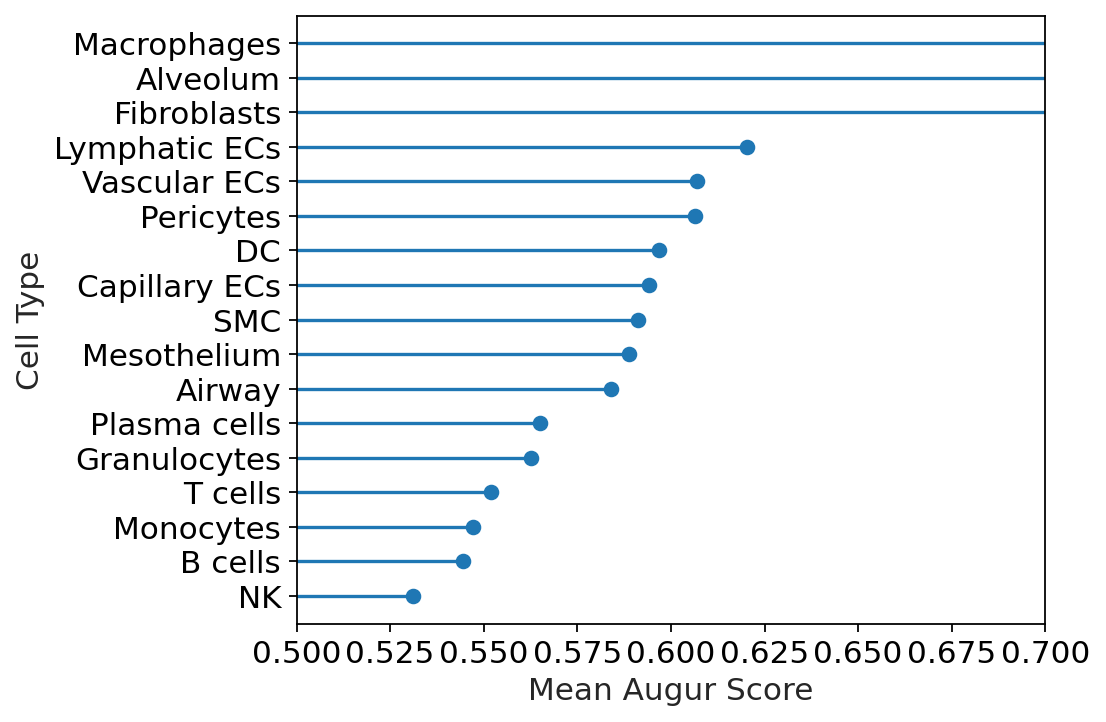

In [32]:
pt.pl.ag.lollipop(d10_results)
plt.xlim([0.5, 0.7])
#plt.yticks(fontsize = 5) 
plt.grid(False)
#plt.savefig(plot_folder + 'pertpy_meta_old.pdf')

In [33]:
important_features = pt.pl.ag.important_features(d10_results, top_n=15)

/tmp/ipykernel_2045766/404253335.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  important_features = pt.pl.ag.important_features(d10_results, top_n=15)


In [34]:
d20_adata, d20_results = ag_rfc.predict(
    loaded_data3, n_subsamples=100, subsample_size=20, n_threads=32, select_variance_features=True
)

d20_results['summary_metrics']

Set smaller span value in the case of a `segmentation fault` error.

Set larger span in case of svddc or other near singularities error.

Output()

Vascular ECs        DC  Capillary ECs    Airway  \
mean_augur_score      0.606769  0.544138       0.632120  0.590374   
mean_auc              0.606769  0.544138       0.632120  0.590374   
mean_accuracy         0.558590  0.530275       0.571832  0.549176   
mean_precision        0.579353  0.541209       0.601675  0.572587   
mean_f1               0.521880  0.461003       0.530128  0.490497   
mean_recall           0.551270  0.456587       0.541905  0.487698   

                  Macrophages  Alveolum   T cells  Monocytes  Plasma cells  \
mean_augur_score     0.651752  0.687925  0.631003   0.626559      0.576372   
mean_auc             0.651752  0.687925  0.631003   0.626559      0.576372   
mean_accuracy        0.596117  0.610220  0.582289   0.586593      0.535861   
mean_precision       0.608178  0.588609  0.636057   0.645104      0.549464   
mean_f1              0.605421  0.671607  0.498285   0.480068      0.453013   
mean_recall          0.662540  0.825635  0.463571   0.432381      0.440794   

                       SMC   B cells  Fibroblasts        NK  Lymphatic ECs  \
mean_augur_score  0.587659  0.559456     0.744994  0.601922       0.605340   
mean_auc          0.587659  0.559456     0.744994  0.601922       0.605340   
mean_accuracy     0.545366  0.537491     0.654267  0.558278       0.566007   
mean_precision    0.546764  0.557380     0.627632  0.585286       0.582007   
mean_f1           0.468691  0.456395     0.703473  0.402824       0.547973   
mean_recall       0.465159  0.446349     0.845794  0.357698       0.591429   

                  Mesothelium  Pericytes  Granulocytes  
mean_augur_score     0.632035   0.629875      0.641202  
mean_auc             0.632035   0.629875      0.641202  
mean_accuracy        0.583901   0.571136      0.580806  
mean_precision       0.647746   0.569883      0.599880  
mean_f1              0.506781   0.562911      0.544411  
mean_recall          0.496032   0.625952      0.557143

In [35]:
pt.pl.ag.lollipop(d20_results)
plt.xlim([0.5, 0.65])
#plt.yticks(fontsize = 5) 
plt.grid(False)
#plt.savefig(plot_folder + 'pertpy_meta_control.pdf')

/tmp/ipykernel_2045766/2650353808.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  pt.pl.ag.lollipop(d20_results)


/tmp/ipykernel_2045766/927551739.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  important_features = pt.pl.ag.important_features(d20_results, top_n=15)


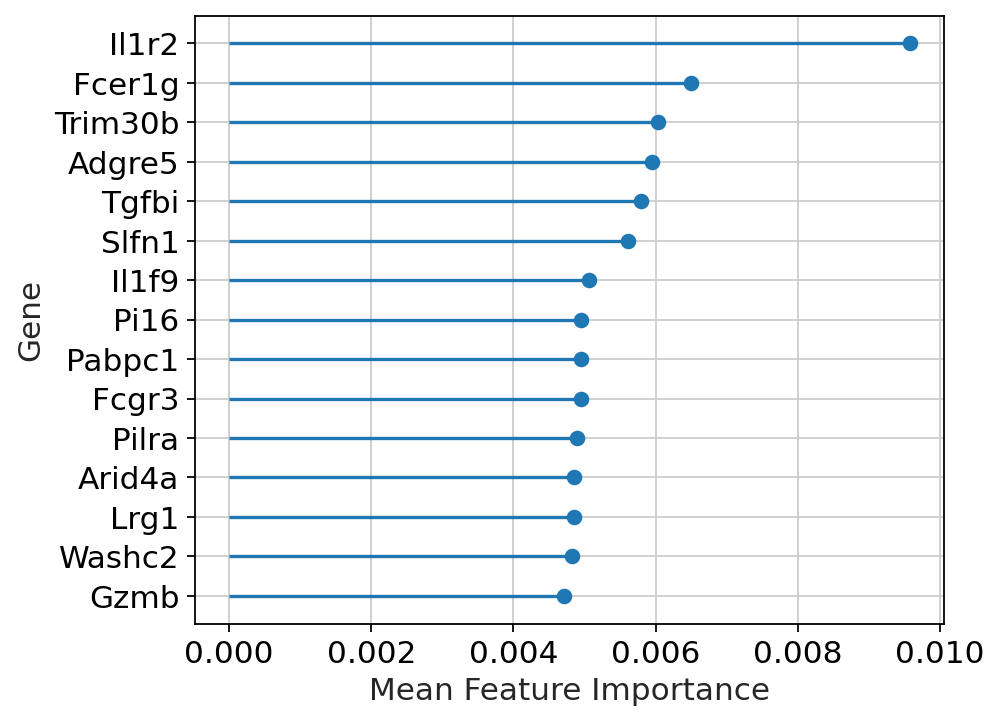

In [36]:
important_features = pt.pl.ag.important_features(d20_results, top_n=15)

In [37]:
d30_adata, d30_results = ag_rfc.predict(
    loaded_data4, n_subsamples=100, subsample_size=20, n_threads=32, select_variance_features=True
)

d30_results['summary_metrics']

Set smaller span value in the case of a `segmentation fault` error.

Set larger span in case of svddc or other near singularities error.

Output()

Skipping SMC cell type - the number of samples for at least one class type is less than subsample size 20.

Skipping Pericytes cell type - the number of samples for at least one class type is less than subsample size 20.

Vascular ECs        DC  Capillary ECs    Airway  \
mean_augur_score      0.568781  0.549830       0.603005  0.524184   
mean_auc              0.568781  0.549830       0.603005  0.524184   
mean_accuracy         0.541484  0.526337       0.560421  0.526136   
mean_precision        0.536215  0.530488       0.565634  0.536258   
mean_f1               0.545722  0.529462       0.574023  0.486674   
mean_recall           0.615714  0.585714       0.646746  0.507857   

                  Macrophages  Alveolum   T cells  Monocytes  Plasma cells  \
mean_augur_score     0.665686  0.643747  0.529938   0.601627      0.589371   
mean_auc             0.665686  0.643747  0.529938   0.601627      0.589371   
mean_accuracy        0.602564  0.582784  0.513187   0.555604      0.544615   
mean_precision       0.595418  0.585712  0.504433   0.588442      0.574335   
mean_f1              0.637588  0.616706  0.483026   0.493051      0.418402   
mean_recall          0.736429  0.720714  0.521032   0.479127      0.372937   

                   B cells  Fibroblasts        NK  Lymphatic ECs  Mesothelium  \
mean_augur_score  0.541905     0.695357  0.528180       0.551780     0.558520   
mean_auc          0.541905     0.695357  0.528180       0.551780     0.558520   
mean_accuracy     0.520110     0.628828  0.505385       0.518480     0.531374   
mean_precision    0.530684     0.603287  0.497338       0.520442     0.530990   
mean_f1           0.516157     0.691974  0.471458       0.497638     0.532414   
mean_recall       0.573889     0.849206  0.516587       0.553413     0.598651   

                  Granulocytes  
mean_augur_score      0.555108  
mean_auc              0.555108  
mean_accuracy         0.532784  
mean_precision        0.543713  
mean_f1               0.483832  
mean_recall           0.492937

/tmp/ipykernel_2045766/1699394114.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  pt.pl.ag.lollipop(d30_results)


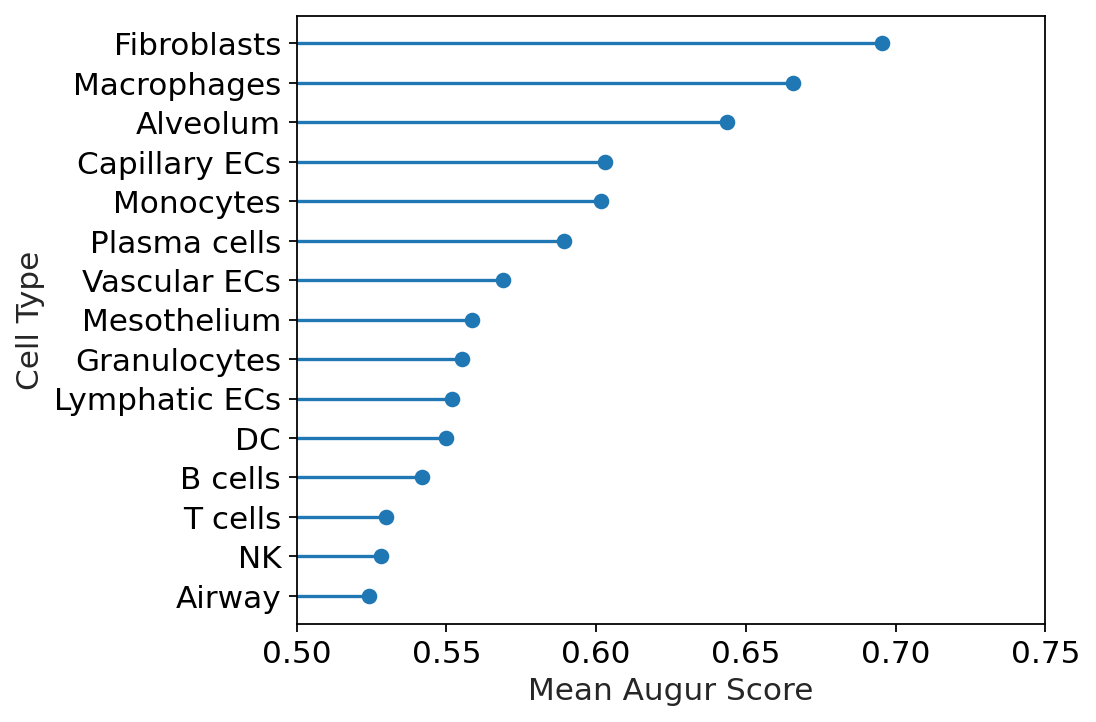

In [38]:
pt.pl.ag.lollipop(d30_results)
plt.xlim([0.5, 0.75])
#plt.yticks(fontsize = 5) 
plt.grid(False)
#plt.savefig(plot_folder + 'pertpy_meta_bleo.pdf')

/tmp/ipykernel_2045766/718609947.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  important_features = pt.pl.ag.important_features(d30_results, top_n=15)


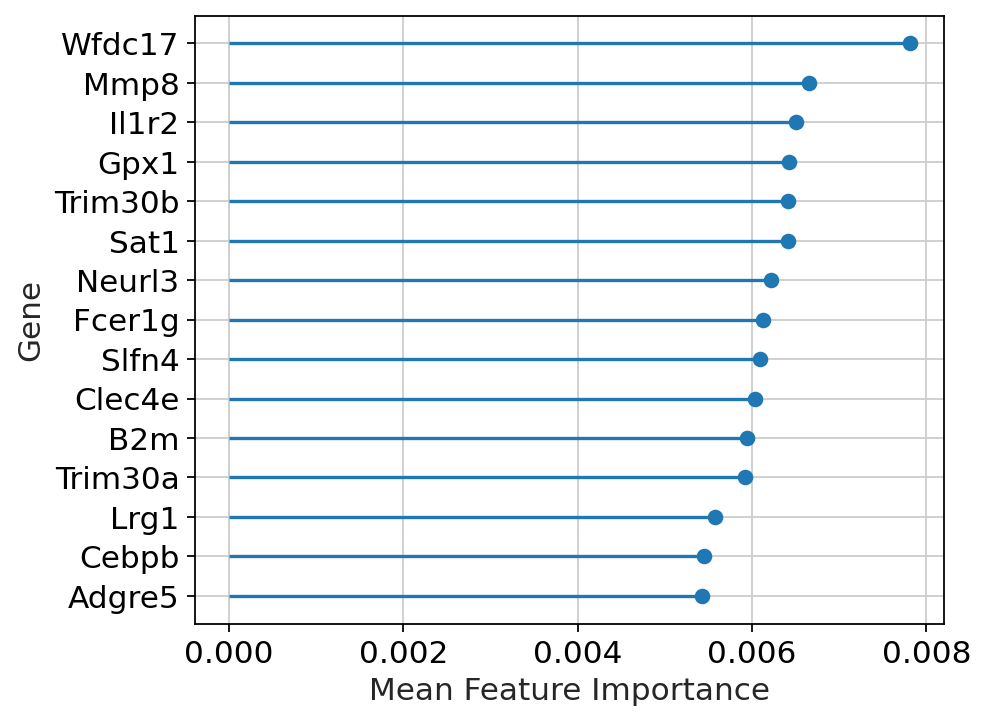

In [39]:
important_features = pt.pl.ag.important_features(d30_results, top_n=15)

In [40]:
d37_adata, d37_results = ag_rfc.predict(
    loaded_data5, n_subsamples=100, subsample_size=20, n_threads=32, select_variance_features=True
)

d37_results['summary_metrics']

Set smaller span value in the case of a `segmentation fault` error.

Set larger span in case of svddc or other near singularities error.

Output()

Skipping SMC cell type - the number of samples for at least one class type is less than subsample size 20.

Skipping NK cell type - the number of samples for at least one class type is less than subsample size 20.

Skipping Pericytes cell type - the number of samples for at least one class type is less than subsample size 20.

Vascular ECs        DC  Capillary ECs    Airway  \
mean_augur_score      0.638101  0.638713       0.687364  0.578929   
mean_auc              0.638101  0.638713       0.687364  0.578929   
mean_accuracy         0.574084  0.565000       0.597125  0.544029   
mean_precision        0.606301  0.604007       0.659438  0.571835   
mean_f1               0.512401  0.461201       0.513421  0.497378   
mean_recall           0.513413  0.435000       0.485635  0.501270   

                  Macrophages  Alveolum   T cells  Monocytes  Plasma cells  \
mean_augur_score     0.600051  0.701769  0.670488   0.687041      0.629728   
mean_auc             0.600051  0.701769  0.670488   0.687041      0.629728   
mean_accuracy        0.563516  0.623663  0.593132   0.599652      0.579286   
mean_precision       0.595064  0.652017  0.640994   0.684056      0.614957   
mean_f1              0.510351  0.588309  0.480362   0.459327      0.511069   
mean_recall          0.509365  0.595159  0.436746   0.384921      0.491587   

                   B cells  Fibroblasts  Lymphatic ECs  Mesothelium  \
mean_augur_score  0.685998     0.718838       0.661259     0.617143   
mean_auc          0.685998     0.718838       0.661259     0.617143   
mean_accuracy     0.605696     0.632088       0.595421     0.568242   
mean_precision    0.620532     0.644718       0.640123     0.593148   
mean_f1           0.593076     0.640920       0.510607     0.510395   
mean_recall       0.623810     0.706270       0.489048     0.520476   

                  Granulocytes  
mean_augur_score      0.659938  
mean_auc              0.659938  
mean_accuracy         0.591941  
mean_precision        0.584415  
mean_f1               0.637933  
mean_recall           0.756270

/tmp/ipykernel_2045766/3721990724.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  pt.pl.ag.lollipop(d37_results)


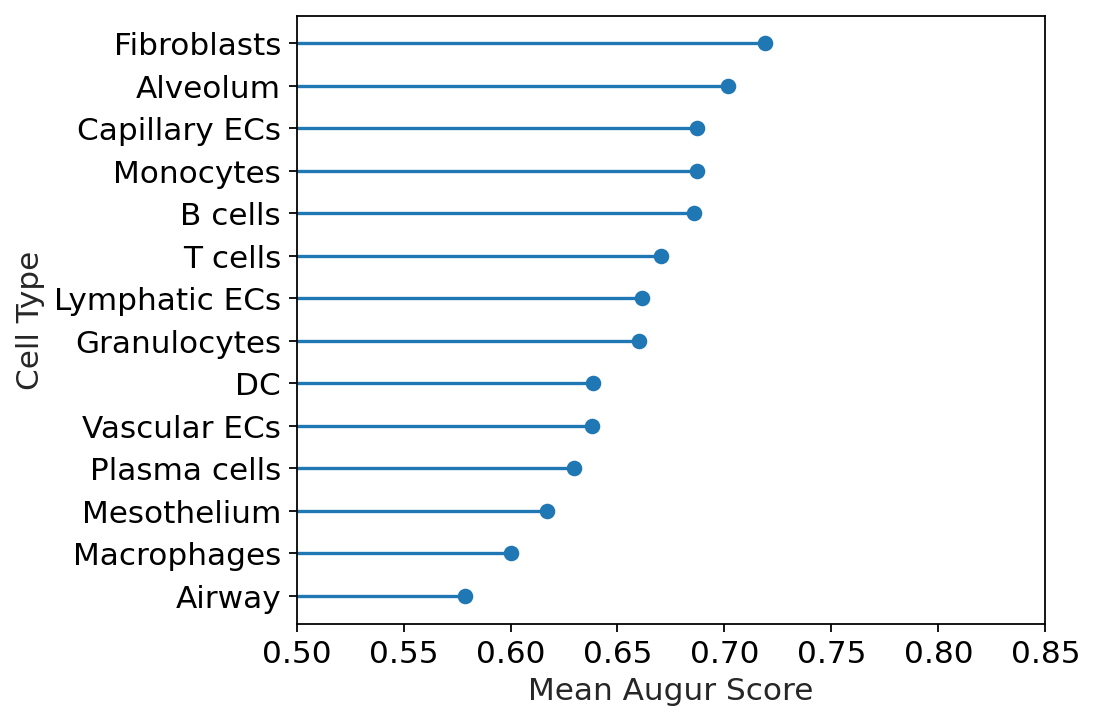

In [41]:
pt.pl.ag.lollipop(d37_results)
plt.xlim([0.5, 0.85])
#plt.yticks(fontsize = 8) 
plt.grid(False)
#plt.savefig(plot_folder + 'pertpy_meta_control.pdf')

/tmp/ipykernel_2045766/82359284.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  important_features = pt.pl.ag.important_features(d37_results, top_n=15)


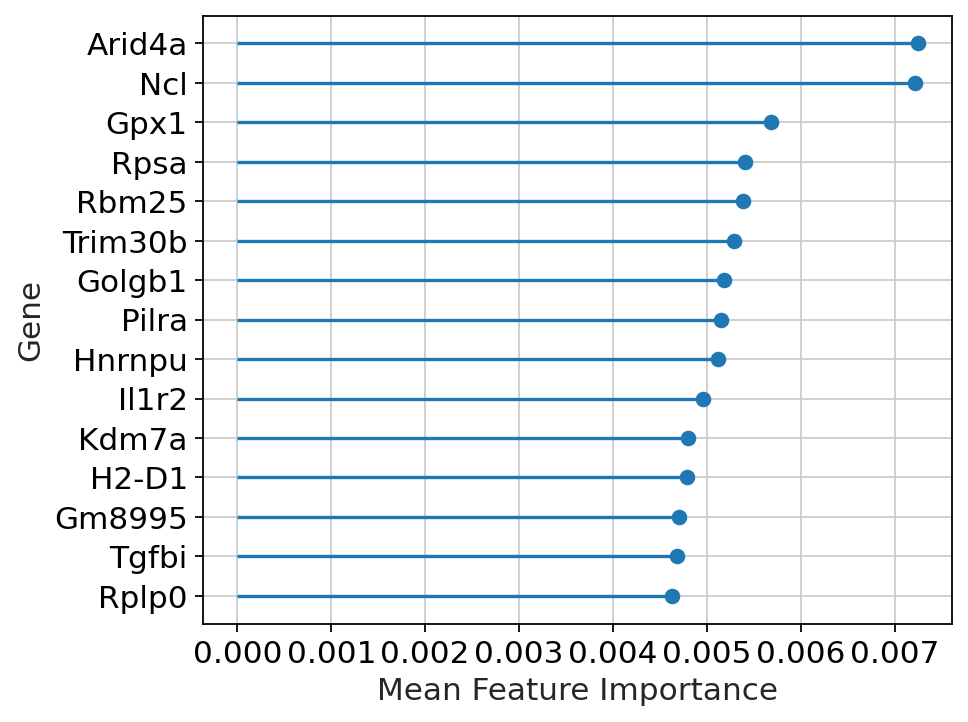

In [42]:
important_features = pt.pl.ag.important_features(d37_results, top_n=15)

In [43]:
sc.pp.neighbors(d37_adata)
sc.tl.umap(d37_adata)
sc.pl.umap(adata=d37_adata	, color=["augur_score", "cell_type"])

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:39)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:54)


### write augur score tables

In [44]:
d3_scores = d3_results['summary_metrics'].loc['mean_augur_score',]
d10_scores = d10_results['summary_metrics'].loc['mean_augur_score',]
d20_scores = d20_results['summary_metrics'].loc['mean_augur_score',]
d30_scores = d30_results['summary_metrics'].loc['mean_augur_score',]
d37_scores = d37_results['summary_metrics'].loc['mean_augur_score',]

In [45]:
d3_scores = pd.DataFrame(d3_scores)
d10_scores = pd.DataFrame(d10_scores)
d20_scores = pd.DataFrame(d20_scores)
d30_scores = pd.DataFrame(d30_scores)
d37_scores = pd.DataFrame(d37_scores)

In [46]:
d3_scores.columns = ['d3']
d10_scores.columns = ['d10']
d20_scores.columns = ['d20']
d30_scores.columns = ['d30']
d37_scores.columns = ['d37']

In [47]:
#all_timpoint_scores = [d0_df, d3_scores, d10_scores, d20_scores, d30_scores, d37_scores]
time_point_scores = pd.concat([d3_scores, d10_scores, d20_scores, d30_scores, d37_scores], axis = 1)#, sort = False)
time_point_scores

d3       d10       d20       d30       d37
Vascular ECs   0.556236  0.606882  0.606769  0.568781  0.638101
DC             0.594161  0.596842  0.544138  0.549830  0.638713
Capillary ECs  0.581531  0.594184  0.632120  0.603005  0.687364
Airway         0.602392  0.584002  0.590374  0.524184  0.578929
Macrophages    0.650397  0.779433  0.651752  0.665686  0.600051
Alveolum       0.700998  0.774541  0.687925  0.643747  0.701769
T cells        0.534127  0.552063  0.631003  0.529938  0.670488
Monocytes      0.553277  0.547029  0.626559  0.601627  0.687041
Plasma cells   0.635181  0.565130  0.576372  0.589371  0.629728
SMC            0.606905  0.591077  0.587659       NaN       NaN
B cells        0.527868  0.544558  0.559456  0.541905  0.685998
Fibroblasts    0.604399  0.757664  0.744994  0.695357  0.718838
NK             0.564059  0.531128  0.601922  0.528180       NaN
Lymphatic ECs  0.537528  0.620300  0.605340  0.551780  0.661259
Mesothelium    0.549546  0.588730  0.632035  0.558520  0.617143
Pericytes      0.538605  0.606417  0.629875       NaN       NaN
Granulocytes   0.556973  0.562727  0.641202  0.555108  0.659938

In [48]:
## Save the Marker Table
out_folder = "/media/HDD_1/Michael/Michelangelo/aging/augurpy/"
time_point_scores.to_csv(out_folder + "time_resolved_augur_scores_old.txt", sep = "\t")